In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() \
                      else "cpu")
print("working on: " + str(DEVICE))

working on: cuda


In [4]:
RANDOM_SEED = 20200101
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# reproducibility with convolutions (btw, we do not use them)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
DB = pd.read_csv("./pmsm_temperature_data.csv")
DBs = [db[1] for db in DB.groupby("profile_id")]
np.random.shuffle(DBs)
print(DB.shape)
print(len(DBs))

(998070, 13)
52


In [6]:
DB.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


In [7]:
TARGET = ["pm"]
FEATURES = ["ambient", "coolant", "u_d", "u_q", "motor_speed", "i_d",
            "i_q", "stator_yoke", "stator_tooth", "stator_winding"]

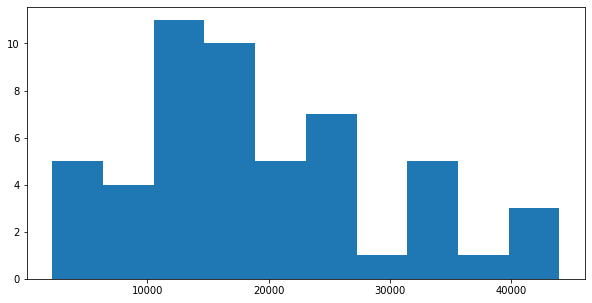

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(list(map(len, DBs)))
plt.show()

In [9]:
train_ratio = int(len(DBs) * 0.75)
TRAIN_SET, TEST_SET = DBs[0:train_ratio], DBs[train_ratio:]
print(len(TRAIN_SET), len(TEST_SET))

39 13


# Neural Networks

In [10]:
BATCH_SIZE = 256
EPOCHS = 20

In [11]:
def plot_history(history):
    train_col = "red"
    test_col = "orange"
    
    for feature in ["loss", "R2"]:
        plt.plot(history[feature + "_train"],
                 label="Train",
                 color=train_col)
        plt.plot(history[feature + "_test"],
                 label="Test",
                 color=test_col)
        plt.xlabel("Epoch")
        plt.ylabel("Value")
        plt.title(feature)
        plt.legend()
        plt.show()

In [12]:
def predict(mod, data):
    "Make predictions using the model"

    # again, to make predictions we should stop dropout
    mod.eval()
    
    prev, data_dataloader = mod.load_data(data, 1)
    Y_hat = []

    # just store results and return them
    for x, _ in data_dataloader():
        y_hat, prev = mod(x, prev)
        Y_hat.append(y_hat.cpu().detach().numpy())

    return np.squeeze(np.vstack(Y_hat))

In [23]:
def plot_result(model, data):
    y_hat = predict(model, data)
    plt.plot(y_hat,
             color="red",
             label="Prevision")
    plt.plot(data[TARGET[0]].values,
             color="black",
             label="Real")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("pm")
    plt.show()

In [14]:
def R2(x, y):
    return np.corrcoef(x, y)[0, 1] ** 2


def evaluate(mod, loss_fn, data, batch_size=1):
    "Return loss and R² of the model given some data"

    # it set the model to evaluation mode (stop dropout and so on)
    mod.eval()

    # resutls for the whole evaluation procedure (return values)
    n_total = []
    loss_total = []
    R2_total = []

    for serie in data:

        n = 0
        loss_serie = 0
        y_serie = []
        yhat_serie = []

        prev, dataloader = mod.load_data(serie, batch_size)

        for X, Y in dataloader():
            Y_hat, prev = mod(X, prev)

            loss_serie += loss_fn(Y_hat.cpu(), Y.cpu()).item()
            y_serie.append(Y[:, 0].cpu().detach().numpy())
            yhat_serie.append(Y_hat[:, 0].cpu().detach().numpy())
            n += len(Y)

        n_total.append(n)
        R2_total.append(R2(y_serie, yhat_serie))
        loss_total.append(loss_serie)
    
    # all is done: return a weighted mean of results
    return np.average(loss_total, weights=n_total), \
           np.average(R2_total,   weights=n_total)


def stop_early(patience_max, times_max=1):
    "Return a earl stopping checker"
    # (from: Goodfellow & Bengio)
    patience = 0
    times = 0
    min_loss = np.Inf

    def check(loss):
        "Return if the train process must stop early"
        nonlocal patience, times, min_loss
        if loss > min_loss:
            patience += 1
            if patience >= patience_max:
                patience = 0
                times += 1
                if times >= times_max:
                    return True
        else:
            min_loss = loss
            patience = 0
        return False
    return check

In [15]:
def train(mod, loss_fn, optimizer,
          train_set, test_set,
          epochs=1, batch_size=BATCH_SIZE,
          early_stopping=None,
          verbose=True):
    "Train the model"

    history = {  # history of the train process
        "time": [],
        "R2_train": [],
        "R2_test": [],
        "loss_train": [],
        "loss_test": []
    }
    
    # repeat for tot epochs
    for epoch in range(epochs):
        
        # it set the model in train mode (start dropout)
        mod.train()

        # just to know how much does it take
        start = datetime.now()

        for db in train_set:
            prev, dataloader = mod.load_data(db, batch_size)

            for X, Y in dataloader():
                optimizer.zero_grad()             # reset gradient
                Y_hat, prev = mod(X, prev)        # make predictions!
                loss = loss_fn(Y_hat, Y)          # compute loss
                loss.backward(retain_graph=True)  # calc direction of GD
                optimizer.step()                  # do a little step to the optimum

        time = datetime.now() - start  # ok, it lasts tot (always too much) seconds

        # just compute and store results
        history["time"].append(time)

        loss, r2 = evaluate(mod, loss_fn, train_set)
        history["R2_train"].append(r2)
        history["loss_train"].append(loss)

        loss, r2 = evaluate(mod, loss_fn, test_set)
        history["R2_test"].append(r2)
        history["loss_test"].append(loss)
        
        # print how good is our model
        if verbose:
            print(epoch + 1, end="\t")
            print(str(time), end="\t")
            for val in ["loss_train", "loss_test", "R2_train", "R2_test"]:
                print(val, end=": ")
                print("%.3f" % history[val][-1], end="\t")
            print("", end="\r")
        
        # stop the process if it start to degenerate
        if early_stopping is not None and early_stopping(history["loss_test"][-1]):
            break

    return history

## Input Recurrent NN

In [20]:
class Custom_RNN(torch.nn.Module):

    def __init__(self, hiddens, recur, p_dropout=0.3):
        self.recur_input, self.recur_output = recur
        # recur_input in [0, len(hiddens)]
        # recur_output in [-1, len(hiddens)]
        assert 0 <= self.recur_input <= len(hiddens)
        assert -1 <= self.recur_output <= len(hiddens)

        super(Custom_RNN, self).__init__()
        input_shape = len(FEATURES)
        output_shape = len(TARGET)
        
        hiddens_in = [input_shape] + hiddens
        hiddens_out = hiddens + [output_shape]
        
        self.previous_size = hiddens_out[self.recur_output] if self.recur_output > 0 \
            else input_shape
        hiddens_in[self.recur_input] += self.previous_size

        self.dropout = torch.nn.Dropout(p=p_dropout)
        self.layers = torch.nn.ModuleList(
            [torch.nn.Linear(in_shape, out_shape) \
             for in_shape, out_shape in zip(hiddens_in, hiddens_out)])
        self.layers_fn = [torch.nn.functional.relu \
                          for _ in range(len(self.layers) - 1)] + \
                              [lambda x: x]

    def initialize_prev(self, data):
        prev = torch.zeros(len(data), self.previous_size)
        _, out = self.forward(data.to(DEVICE), prev.to(DEVICE))
        return out

    def load_data(self, data, batch_size=1):
        X = torch.from_numpy(data[FEATURES].values).float()
        Y = torch.from_numpy(data[TARGET].values).float()
        N, P = X.shape
        K = int(np.floor(N / batch_size))
        if K == N:
            K = 1
        index = np.array(list(range(0, N, K))[0:-1])
        prev = self.initialize_prev(
            torch.stack([X[i - 1] if i > 0
                         else torch.zeros(len(FEATURES))
                         for i in index]))

        def next_observation():
            nonlocal X, Y, index, K
            while index[0] < K:
                yield X[index].to(DEVICE), Y[index].to(DEVICE)
                index += 1

        return prev.to(DEVICE), next_observation

    def forward(self, x_new, x_lagged):
        out, prev = x_new, x_lagged
        for i, (layer, fn) in enumerate(zip(self.layers, self.layers_fn)):
            if i == self.recur_input:
                out = torch.cat([out, x_lagged], axis=1)
            out = fn(layer(out))
            out = self.dropout(out)
            if i == self.recur_output:
                prev = out
        return out, prev


model = Custom_RNN([10, 5], (1, 2)).to(DEVICE)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters())
print(model)

Custom_RNN(
  (dropout): Dropout(p=0.3, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=11, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
)


L'output del livello 2 è collegato all'input del livello 0 (contando da 0);
per far sì che si iteri sull'input basta mettere come terzo parametro -1

In [21]:
history = train(model, loss_fn, optimizer,
                TRAIN_SET, TEST_SET,
                EPOCHS, BATCH_SIZE,
                early_stopping=stop_early(5, 2))

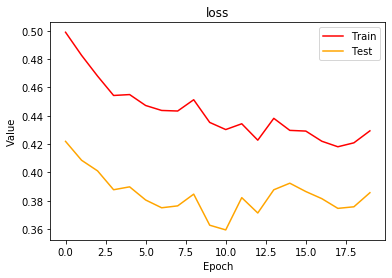

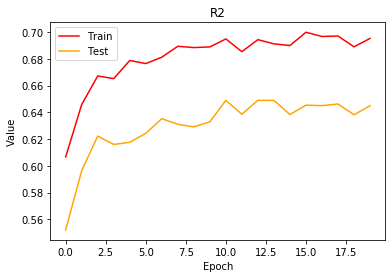

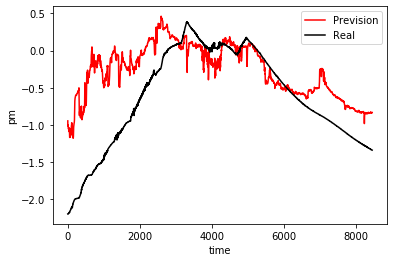

In [24]:
plot_history(history)
plot_result(model, TEST_SET[0])